# **INTRODUCTION**
This method uses reviews data on various food items to.... <br>



## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

## Loading Data

In [ ]:
all_data = []     # stores entire dataset as a 2d list
with open('/content/drive/MyDrive/DataSet/small_dataset.txt') as reviews_file:
  lines = reviews_file.readlines()    # store all the lines
  for line in lines:
    if line == '\n':
      #blank line, skip
      continue
    if line.startswith('product/productId'):
      row = []
      row.append(line.split(" ")[1][:-1]) # [:-1] removes the '\n' character from the string, split to get the value from key value string.
    elif line.startswith('review/userId'):
      row.append(line.split(" ")[1][:-1])
    elif line.startswith('review/profileName'):
      row.append(' '.join(line.split(" ")[1:])[:-1])
    elif line.startswith('review/helpfulness'):
      row.append(line.split(" ")[1][:-1])
    elif line.startswith('review/score'):
      row.append(line.split(" ")[1][:-1])
    elif line.startswith('review/time'):
      row.append(line.split(" ")[1][:-1])
    elif line.startswith('review/summary'):
      row.append(' '.join(line.split(" ")[1:])[:-1])
    elif line.startswith('review/text'):
      row.append(' '.join(line.split(" ")[1:])[:-1]) # used join to join all the words in the review text
      print(row)
      all_data.append(row) # since this is the last attribute

['B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', '1/1', '5.0', '1303862400', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.']
['B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', '0/0', '1.0', '1346976000', 'Not as Advertised', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".']
['B000LQOCH0', 'ABXLMWJIXXAIN', 'Natalia Corres "Natalia Corres"', '1/1', '4.0', '1219017600', '"Delight" says it all', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a t

In [ ]:
reviews_df = pd.DataFrame(all_data,columns=('productId','userId','profileName','helpfulness','score','time','summary','text'))
reviews_df

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0/0,4.0,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0/0,5.0,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0/0,5.0,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1/1,5.0,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0/0,5.0,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


##Exploraratory Data Analysis

In [ ]:
reviews_df.describe()

,productId,userId,profileName,helpfulness,score,time,summary,text
count,14,14,14,14,14,14,14,14
unique,10,14,14,5,4,14,14,14
top,B006K2ZZ7K,ABXLMWJIXXAIN,Carol A. Reed,0/0,5.0,1107820800,fresh and greasy!,My cats have been happily eating Felidae Plati...
freq,4,1,1,6,8,1,1,1


# Data Pre-Processing

Generate a single review string by concatenating all the reviews made by a user.

In [ ]:
unique_users = reviews_df['userId'].unique()# list of unique users
user_reviews = []
for user in unique_users:
  review = []
  user_df = reviews_df[reviews_df['userId']==user]
  review.append(user)
  review.append("")  # empty string for summary at index 1
  review.append("")  # empty string for review at index 2
  #dropped column time and helfulness
  for index, row in user_df.iterrows():
    review[1] += row['summary']
    review[2] += row['text']
  print(review)
  user_reviews.append(review)

['A3SGXH7AUHU8GW', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.']
['A1D87F6ZCVE5NK', 'Not as Advertised', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".']
['ABXLMWJIXXAIN', '"Delight" says it all', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardr

In [ ]:
concatenated_reviews_df = pd.DataFrame(user_reviews,columns=('userId','summary','text'))
concatenated_reviews_df

,userId,summary,text
0,A3SGXH7AUHU8GW,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,"""Delight"" says it all",This is a confection that has been around a fe...
3,A395BORC6FGVXV,Cough Medicine,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,Great taffy,Great taffy at a great price. There was a wid...
5,ADT0SRK1MGOEU,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,A1SP2KVKFXXRU1,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,A3JRGQVEQN31IQ,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,A1MZYO9TZK0BBI,Yay Barley,Right now I'm mostly just sprouting this so my...
9,A21BT40VZCCYT4,Healthy Dog Food,This is a very healthy dog food. Good for thei...


# Tokenization and TF-IDF

In [ ]:
corpus = concatenated_reviews_df['text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
features_list = vectorizer.get_feature_names()
num_features = len(features_list)
print("Number of Features:", num_features)
tf_idf = vectorizer.transform(corpus)

Number of Features: 349


In [ ]:
tf_idf_df = pd.DataFrame(tf_idf.todense(), index=concatenated_reviews_df['userId'], columns=features_list)
tf_idf_df

,about,actually,addition,all,also,amazing,amount,an,and,any,anywhere,appreciates,are,around,arrived,as,assortment,at,away,back,bag,be,beach,because,been,beer,believe,better,between,bit,black,blown,both,bottle,bought,bowls,boy,boys,br,brand,...,tried,trip,twizzlers,two,unfortunately,unique,unsalted,up,us,use,ve,vendor,version,very,vitality,want,wardrobe,was,watermelon,we,week,weeks,weight,well,were,wheatgrass,when,where,which,wide,wild,will,witch,with,would,wrapped,years,you,your,yummy
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A3SGXH7AUHU8GW,0.000000,0.000000,0.000000,0.139343,0.000000,0.000000,0.000000,0.000000,0.195946,0.000000,0.000000,0.160994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160994,0.000000,0.000000,0.000000,0.000000,0.000000,0.321989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160994,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1D87F6ZCVE5NK,0.000000,0.175343,0.000000,0.000000,0.000000,0.000000,0.000000,0.151762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175343,0.350686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175343,0.000000,0.000000,0.000000,0.000000,0.175343,0.000000,0.000000,0.000000,0.000000,0.000000,0.111449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABXLMWJIXXAIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264068,0.000000,0.000000,0.000000,0.075513,0.093893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058601,0.000000,0.000000,0.108483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216965,0.226538,0.000000,0.000000,0.000000,0.075513,0.000000,0.093893
A395BORC6FGVXV,0.000000,0.000000,0.202853,0.000000,0.000000,0.000000,0.000000,0.000000,0.082297,0.000000,0.000000,0.000000,0.141202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175572,0.202853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109578,0.000000,0.000000,0.000000,0.128935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141202,0.000000,0.000000
A1UQRSCLF8GW1T,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222743,0.171533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

# Dimensionality Reduction

In [ ]:
explained_variance_ratio_sum = []
for n in range(1,num_features):
  # get explained variance ratio sum for number of features = n in range (1, number of features-1 i.e. 372)
  svd = TruncatedSVD(n_components=n)
  svd.fit(tf_idf_df)
  transformed_tf_idf = svd.transform(tf_idf_df)
  explained_variance_ratio_sum.append(svd.explained_variance_ratio_.sum())

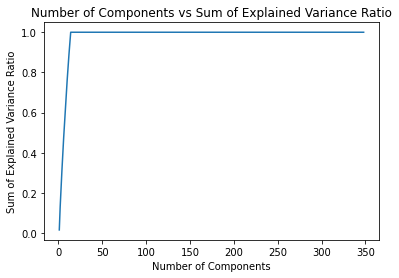

In [ ]:
plt.plot(range(1,num_features),explained_variance_ratio_sum)
plt.xlabel("Number of Components")
plt.ylabel("Sum of Explained Variance Ratio")
plt.title("Number of Components vs Sum of Explained Variance Ratio")
plt.show()

Take point of infection as the number of components


In [ ]:
svd = TruncatedSVD(n_components=150)
svd.fit(tf_idf_df)
transformed_tf_idf = svd.transform(tf_idf_df)
transformed_tf_idf_df = pd.DataFrame(transformed_tf_idf,index=tf_idf_df.index)
transformed_tf_idf_df # matrix with reduced features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
userId,,,,,,,,,,,,,,
A3SGXH7AUHU8GW,0.416160,-0.290310,0.282890,-0.019889,0.110006,-0.221410,-0.048315,-0.117197,0.716402,-0.230987,-0.023286,-0.097513,-0.072309,-0.055219
A1D87F6ZCVE5NK,0.271743,-0.127796,0.222087,-0.527284,0.434088,0.317989,0.519342,-0.039624,-0.088818,0.035343,-0.031978,-0.049932,0.029054,0.090222
ABXLMWJIXXAIN,0.565969,0.011429,-0.283293,-0.116866,-0.050560,-0.253801,0.181853,-0.054303,-0.010701,-0.037928,0.511688,0.368885,0.204702,-0.203197
A395BORC6FGVXV,0.503569,0.015857,0.056992,-0.024877,0.274424,-0.256754,-0.229147,-0.444382,-0.421598,-0.209508,-0.247527,-0.008177,-0.146445,-0.216021
A1UQRSCLF8GW1T,0.323677,0.583378,0.237791,-0.099700,-0.042154,0.330384,-0.155318,0.220678,0.098358,-0.153951,-0.040420,0.404816,-0.320484,-0.055404
ADT0SRK1MGOEU,0.491847,0.307577,0.165272,0.047773,-0.303935,0.333863,-0.102466,-0.152958,-0.067703,-0.324990,0.152494,-0.343981,0.365590,0.103504
A1SP2KVKFXXRU1,0.472038,0.421051,-0.072162,-0.058648,0.076316,-0.023215,-0.092857,-0.015985,0.198443,0.600073,-0.255581,-0.101683,0.243774,-0.203604
A3JRGQVEQN31IQ,0.522612,0.379519,-0.159753,0.178441,0.020100,-0.337902,0.233781,0.002172,-0.018754,0.086371,0.086486,-0.182230,-0.301588,0.465602
A1MZYO9TZK0BBI,0.384059,-0.185735,-0.473721,0.235098,-0.318917,0.280632,0.391255,0.001051,0.060129,-0.132115,-0.301688,-0.058012,-0.168342,-0.246952


In [ ]:
neighbourhood = kneighbors_graph(transformed_tf_idf_df, 10, mode='distance', include_self=True,metric='euclidean')
neighbourhood_df = pd.DataFrame(neighbourhood.toarray())
neighbourhood_df  # values are distance or similarity? why zeroes if distance?   #dimensions = n*n

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,1.336310,1.302124,1.305981,0.000000,1.340802,0.000000,1.339766,0.000000,1.320361,1.336288,1.289624,1.261243,0.000000
1,1.336310,0.000000,1.343556,1.333199,1.364750,1.371330,1.361570,0.000000,0.000000,0.000000,1.344325,1.334631,1.348914,0.000000
2,1.302124,0.000000,0.000000,1.263013,0.000000,1.290130,1.277979,1.208905,1.278843,0.000000,1.270014,1.302375,1.267562,0.000000
3,1.305981,1.333199,1.263013,0.000000,0.000000,1.289255,1.296144,1.259473,0.000000,0.000000,1.313310,1.321884,1.276400,0.000000
4,1.391279,1.364750,1.348121,1.352191,0.000000,1.221879,1.251739,1.292349,0.000000,1.367908,1.377870,0.000000,0.000000,0.000000
5,1.340802,0.000000,1.290130,1.289255,1.221879,0.000000,1.277843,1.265152,1.310884,0.000000,0.000000,1.304057,1.316897,0.000000
6,1.350634,0.000000,1.277979,1.296144,1.251739,1.277843,0.000000,1.207143,1.355593,0.000000,1.335379,0.000000,1.343557,0.000000
7,1.339766,0.000000,1.208905,1.259473,1.292349,1.265152,1.207143,0.000000,1.307045,1.321322,1.327900,0.000000,0.000000,0.000000
8,1.363155,0.000000,1.278843,0.000000,0.000000,1.310884,1.355593,1.307045,0.000000,0.000000,1.325945,1.325007,1.260228,1.350957
9,1.320361,0.000000,1.376931,1.341764,1.367908,1.349973,0.000000,1.321322,0.000000,0.000000,0.000000,1.318637,1.333703,1.377769


# Graph Generation

In [ ]:
#### ITERATE OVER EACH CELL AND ADD EDGES OF THE GRAPH
edges = []
for col in neighbourhood_df.columns:
  for row in neighbourhood_df.index:
    weight = neighbourhood_df[col][row]
    if weight != 0:
      edge = []
      edge.append(row)
      edge.append(col)
      edge.append(weight)
      edges.append(edge)
edges

[[1, 0, 1.3363099715961235],
 [2, 0, 1.3021242152419215],
 [3, 0, 1.305981488786884],
 [4, 0, 1.3912792969234942],
 [5, 0, 1.3408015472544657],
 [6, 0, 1.3506335903653313],
 [7, 0, 1.3397661775759988],
 [8, 0, 1.3631548770627937],
 [9, 0, 1.3203611737480523],
 [10, 0, 1.3362880478420691],
 [11, 0, 1.2896242976117969],
 [12, 0, 1.261243368564144],
 [13, 0, 1.3854431183575975],
 [0, 1, 1.3363099715961235],
 [3, 1, 1.333198937394567],
 [4, 1, 1.3647497121215022],
 [10, 1, 1.3443248655763764],
 [11, 1, 1.334630551415827],
 [0, 2, 1.3021242152419215],
 [1, 2, 1.3435558931556204],
 [3, 2, 1.263013376881544],
 [4, 2, 1.3481207353810558],
 [5, 2, 1.290129926029952],
 [6, 2, 1.2779790681331649],
 [7, 2, 1.2089048470585955],
 [8, 2, 1.2788425690629122],
 [9, 2, 1.3769314772633692],
 [10, 2, 1.2700135428629886],
 [11, 2, 1.3023745374625497],
 [12, 2, 1.2675622449450963],
 [0, 3, 1.305981488786884],
 [1, 3, 1.333198937394567],
 [2, 3, 1.263013376881544],
 [4, 3, 1.3521911953920702],
 [5, 3, 1.2892

{(0, 2): Text(-0.07889839131722759, 0.09381656501173752, '1.3021242152419215'),
 (0, 3): Text(-0.14019008435352787, -0.07296688416233654, '1.305981488786884'),
 (0, 4): Text(-0.06283558106244475, 0.4808699168188511, '1.3912792969234942'),
 (0, 5): Text(0.17999281965691913, -0.2568986002982933, '1.3408015472544657'),
 (0, 6): Text(0.3049982098400227, -0.022589825013750814, '1.3506335903653313'),
 (0, 7): Text(0.5033955011020492, 0.20846390744973953, '1.3397661775759988'),
 (0, 8): Text(0.41203692781272083, -0.28604175582259145, '1.3631548770627937'),
 (0, 9): Text(0.3097932494004804, 0.2959205722786108, '1.3203611737480523'),
 (0, 10): Text(-0.2275100695647381, 0.21258854710653324, '1.3362880478420691'),
 (0,
  11): Text(-0.23060106759194296, -0.31006827685235244, '1.2896242976117969'),
 (0,
  12): Text(-0.003782300144144178, -0.37200864559841473, '1.261243368564144'),
 (0, 13): Text(0.12830749409558442, 0.2834575825324572, '1.3854431183575975'),
 (1,
  0): Text(-0.44593575382965905, -0

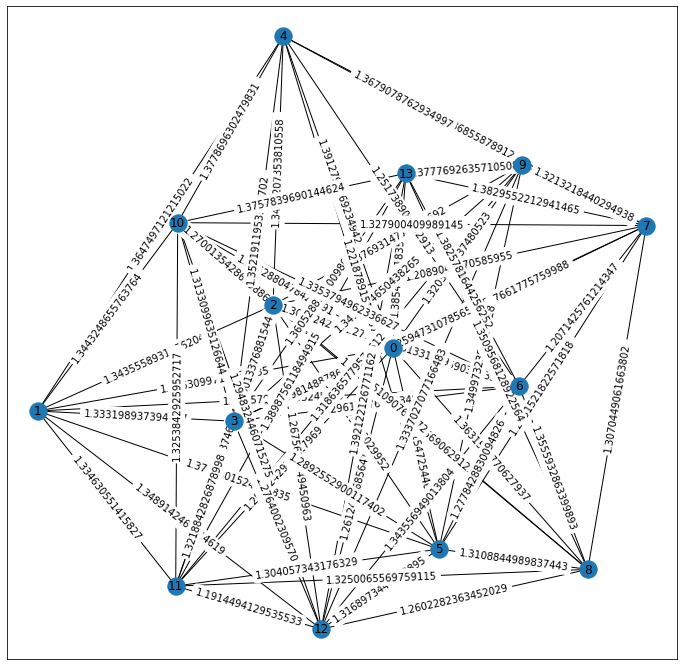

In [ ]:
FG = nx.Graph()
FG.add_weighted_edges_from(edges)
pos=nx.spring_layout(FG)
plt.figure(figsize=(12,12))
nx.draw_networkx(FG,pos)
labels = nx.get_edge_attributes(FG,'weight')
nx.draw_networkx_edge_labels(FG,pos,edge_labels=labels)

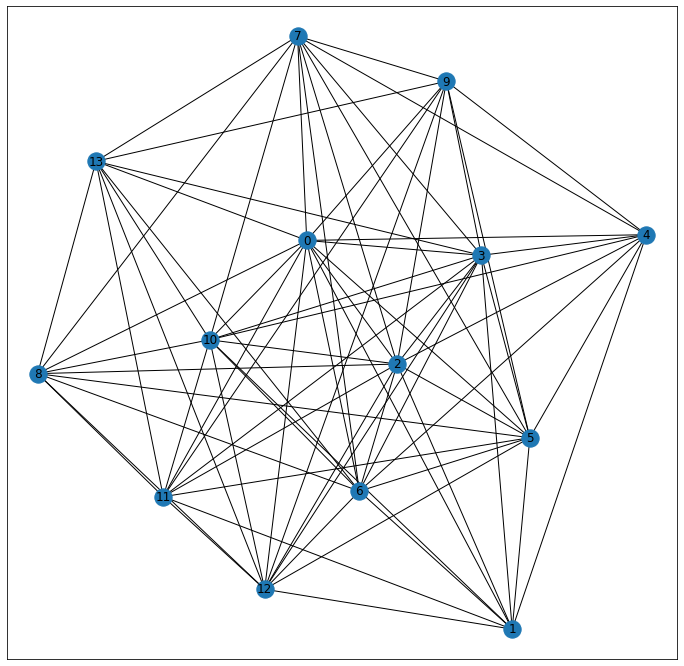

In [ ]:
#Unlabelled Graph
FG = nx.Graph()
FG.add_weighted_edges_from(edges)
pos=nx.spring_layout(FG)
plt.figure(figsize=(12,12))
nx.draw_networkx(FG,pos)

# Community Detection

In [ ]:
c = list(k_clique_communities(FG, 6))
print(c)

[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13})]


In [ ]:
pr = nx.pagerank(FG, alpha=0.9)

In [ ]:
pr

{0: 0.08824628519437916,
 1: 0.06358467190287051,
 2: 0.07975317462244372,
 3: 0.08060036635707477,
 4: 0.06287972860788482,
 5: 0.07416699130753954,
 6: 0.07458204298915436,
 7: 0.0674288523050752,
 8: 0.062465873783374155,
 9: 0.06361097303481514,
 10: 0.07551455870877492,
 11: 0.06830677036306584,
 12: 0.07385813344814644,
 13: 0.06500157737540133}